Log-Gabor Filter
==========

This is an implementation of the Log-Gabor Filter.

In [2]:
# Common imports (you may not end up using all of them)
import numpy as np
import numpy.fft as fft
import scipy.ndimage as ndi
import skimage as ski
import skimage.io as io
import skimage.exposure as ex
import matplotlib.pylab as plt
import math

import skimage.filters as filters

plt.gray() # set default to grayscale

<Figure size 432x288 with 0 Axes>

In [3]:
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

Already up to date.


In [4]:
# Utilities

def fft_convolve(im1, im2):
  '''
  Convolves two images by converting them into fourier space and multiplying them.

  Arguments:
    im1 the first image to convolve
    im2 the second image to convolve

  Returns:
    the result of the convolution.
  '''
  return fft.ifft2(
      fft.fft2(im1) *
      fft.fft2(im2, s=im1.shape)
  ).real

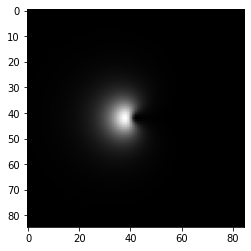

In [38]:
def log_gabor_kernel(frequency, theta, size=7, wavelength=3, sigma=0.5, angle=np.pi, thetaSigma=1):
    '''
    Convolves two images by converting them into fourier space and multiplying them.

    Arguments:
        frequency
        theta       direction
        size        size (width and height) of the kernel
        wavelength  
        sigma

    Returns:
        a log-gabor kernel
        '''
    if size < 3 or size % 2 == 0 or (not isinstance(size, int)):
        raise ValueError('size is invalid value: ' + str(size))

    num_rows = size
    num_cols = size

    x = np.arange(-(num_cols // 2), (num_cols // 2) + 1) / num_cols
    y = np.arange(-(num_rows // 2), (num_rows // 2) + 1) / num_rows
    [x,y] = np.meshgrid(x, y)

    radius = np.sqrt(x**2 + y**2)

    radius[(num_rows // 2), (num_cols // 2)] = 1

    frequency = 1.0 / wavelength

    g = np.exp((-(np.log(radius/frequency)) ** 2) / (2 * (np.log(sigma) ** 2)))
    g[num_rows // 2, num_cols // 2] = 0

    # skipping low pass filter for now

    #calculate the angular component that controls the orientation selectivity of the filter.
    theta = np.arctan2(-y, x)
    sintheta = np.sin(theta)
    costheta = np.cos(theta)

    #abs difference in sine and cosine
    ds = sintheta * np.cos(angle) - costheta * np.sin(angle)
    dc = costheta * np.cos(angle) + sintheta * np.sin(angle)

    #calculate absolute angular distance
    dtheta = np.abs(np.arctan2(ds,dc))

    #calc angular
    spread = np.exp((-dtheta ** 2) / (2 * (thetaSigma ** 2)))

    filter = spread * g
    plt.imshow(filter)

    return None

log_gabor_kernel(0.5, 0, size=85, wavelength=20, sigma=0.5)


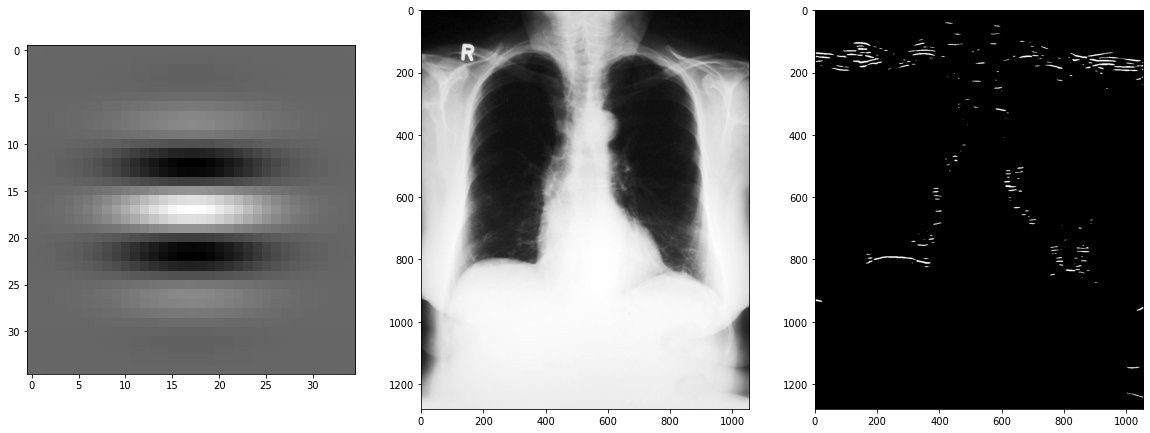

In [79]:
im = io.imread('ImageProcessingF2021/images/xray.png')

k = filters.gabor_kernel(0.1, 2 * math.pi * (24 / 32)).real

plt.figure(figsize=(20, 20))

num_cols = 3

plt.subplot(1, num_cols, 1)
plt.imshow(k)

plt.subplot(1, num_cols, 2)
plt.imshow(im)

plt.subplot(1, num_cols, 3)
plt.imshow(ndi.convolve(im, k))